### Imports

In [1]:
from functions.load_data import load_CIFAR_data, shuffle_data
from functions.attacks import attackTestSetBatch
#from functions.models import simple_conv_trop_model, simple_conv_relu_model, simple_3layer_conv_relu_model, simple_3layer_conv_relu_model_with_trop_logits
from tensorflow.keras import losses
import numpy as np
from tensorflow.keras.utils import plot_model
from custom_layers.tropical_layers import TropConv2D
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Conv2D
from tensorflow.keras import initializers
from tensorflow.keras.models import load_model
from functions.tests import test_pdg_steps
import csv
import os
from pathlib import Path

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'  # Modify this path to your Graphviz installation directory

### LOAD DATA

In [2]:
# -- load CIFAR data --
x_train, x_test, y_train, y_test = load_CIFAR_data(desired_classes=[i for i in range(10)])
x_train = x_train.reshape(-1,32,32,3)
x_test = x_test.reshape(-1,32,32,3)

In [3]:
from custom_layers.tropical_layers import TropEmbedMaxMinLogits

trop_model = load_model("saved_models/tropmodel_trop_logitsCIFAR.h5", custom_objects={'TropEmbedMaxMinLogits':TropEmbedMaxMinLogits})
relu_model = load_model("saved_models/relumodel_trop_logitsCIFAR.h5")
file_path = 'output_data/CIFAR_conv3layer_tropLogits_attacks.csv'

test_pdg_steps(file_path, x_test, y_test, 
               min_steps = 1, max_steps = 51, step_size = 2, eps=8/255, 
               trop_model=trop_model, relu_model=relu_model)



1


Tropical model 0% attacked.
Tropical model 8% attacked.
Tropical model 16% attacked.
Tropical model 24% attacked.
Tropical model 32% attacked.
Tropical model 40% attacked.
Tropical model 48% attacked.
Tropical model 56% attacked.
Tropical model 64% attacked.
Tropical model 72% attacked.
Tropical model 80% attacked.
Tropical model 88% attacked.
Tropical model 96% attacked.
Tropical attack complete. Elapsed time: 21.87 seconds | 0.36 minutes.
313/313 [==============================] - 2s 6ms/step - loss: 2.7032 - accuracy: 0.1964


3


Tropical model 0% attacked.
Tropical model 8% attacked.
Tropical model 16% attacked.
Tropical model 24% attacked.
Tropical model 32% attacked.
Tropical model 40% attacked.
Tropical model 48% attacked.
Tropical model 56% attacked.
Tropical model 64% attacked.
Tropical model 72% attacked.
Tropical model 80% attacked.
Tropical model 88% attacked.
Tropical model 96% attacked.
Tropical attack complete. Elapsed time: 33.36 seconds | 0.56 minutes.
313/313 [

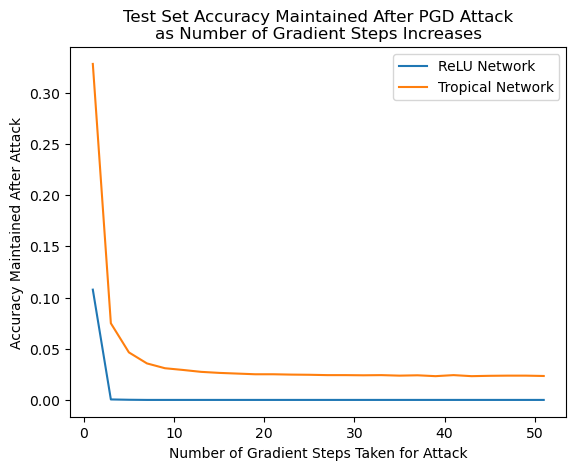

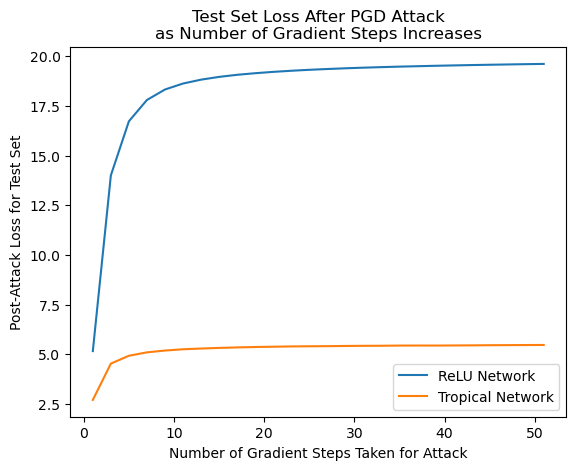

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

file_path='output_data/CIFAR_conv3layer_tropLogits_attacks.csv'
all_data = pd.read_csv(file_path)
trop_res = all_data[all_data['model_type']=='trop']
relu_res = all_data[all_data['model_type']=='relu']

plt.plot(relu_res['attack'], relu_res['maintained_correct_pred'], label='ReLU Network')
plt.plot(trop_res['attack'], trop_res['maintained_correct_pred'], label='Tropical Network')

plt.title('Test Set Accuracy Maintained After PGD Attack\nas Number of Gradient Steps Increases')
plt.xlabel('Number of Gradient Steps Taken for Attack')
plt.ylabel('Accuracy Maintained After Attack')
#plt.xlim((0,40))
plt.legend()
plt.show()

plt.plot(relu_res['attack'], relu_res['post_loss'], label='ReLU Network')
plt.plot(trop_res['attack'], trop_res['post_loss'], label='Tropical Network')

plt.title('Test Set Loss After PGD Attack\nas Number of Gradient Steps Increases')
plt.xlabel('Number of Gradient Steps Taken for Attack')
plt.ylabel('Post-Attack Loss for Test Set')
#plt.xlim((0,40))
plt.legend()
plt.show()

In [5]:
file_path = "output_data/CIFAR_trop_logits.csv" 
if not Path(file_path).is_file():
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['pre_loss', 'pre_acc', 'post_loss', 'post_acc', 'maintained_correct_pred', 'model_type'])

step_num = 20
eps = 8/255
num_epochs = 10
for i in range(1):
    print(f'\n\n{i}\n\n')    
    # -- TROPICAL: fit model --
    trop_model = simple_3layer_conv_relu_model_with_trop_logits(x_train=x_train, y_train=y_train, num_epochs=num_epochs, initializer_w = initializers.RandomNormal(0, 0.05))
    
    # -- TROPICAL: attack model -- 
    trop_x_test_att = attackTestSetBatch(trop_model, x_test, y_test,  epsilon=eps, loss_object=losses.CategoricalCrossentropy(),modelName='Tropical', num_steps=step_num)

    # -- TROPICAL: evaluate -- 
    # - before attack -
    pre_trop_preds = np.argmax(trop_model.predict(x_test), axis=1)
    y_tester = np.argmax(y_test, axis=1)
    pre_correct_index = np.equal(pre_trop_preds, y_tester)
    pre_loss, pre_acc = trop_model.evaluate(x_test, y_test)

    # - after attack - 
    post_trop_preds = np.argmax(trop_model.predict(trop_x_test_att), axis=1)
    post_loss, post_acc = trop_model.evaluate(trop_x_test_att, y_test)

    # - number maintaining prediction - 
    maintained_correct_pred = np.average(np.equal(post_trop_preds[pre_correct_index], y_tester[pre_correct_index]))

    data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred, 'trop']
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)
    
    # -- RELU: fit model --
    relu_model = simple_3layer_conv_relu_model(x_train=x_train, y_train=y_train, num_epochs=num_epochs)

    # -- RELU: attack model -- 
    relu_x_test_att = attackTestSetBatch(relu_model, x_test, y_test,  epsilon=eps, loss_object=losses.CategoricalCrossentropy(), modelName='ReLU', num_steps=step_num)

    # -- RELU: evaluate --
    # - before attack -
    pre_relu_preds = np.argmax(relu_model.predict(x_test), axis=1)
    y_tester = np.argmax(y_test, axis=1)
    pre_correct_index = np.equal(pre_relu_preds, y_tester)
    pre_loss, pre_acc = relu_model.evaluate(x_test, y_test)

    # - after attack - 
    post_relu_preds = np.argmax(relu_model.predict(relu_x_test_att), axis=1)
    post_loss, post_acc = relu_model.evaluate(relu_x_test_att, y_test)

    # - number maintaining prediction - 
    maintained_correct_pred = np.average(np.equal(post_relu_preds[pre_correct_index], y_tester[pre_correct_index]))

    data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred, 'relu']
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)

np.save('saved_models/trop_x_test_att_trop_logitsCIFAR.npy', trop_x_test_att)
np.save('saved_models/relu_x_test_att_trop_logitsCIFAR.npy', relu_x_test_att)
trop_model.save("saved_models/tropmodel_trop_logitsCIFAR.h5")
relu_model.save("saved_models/relumodel_trop_logitsCIFAR.h5")



0


Epoch 1/10
782/782 [==============================] - 27s 30ms/step - loss: 2.1075 - accuracy: 0.2288
Epoch 2/10
782/782 [==============================] - 24s 31ms/step - loss: 1.7595 - accuracy: 0.3686
Epoch 3/10
782/782 [==============================] - 25s 33ms/step - loss: 1.5455 - accuracy: 0.4498
Epoch 4/10
782/782 [==============================] - 23s 29ms/step - loss: 1.3918 - accuracy: 0.5120
Epoch 5/10
782/782 [==============================] - 24s 30ms/step - loss: 1.2845 - accuracy: 0.5523
Epoch 6/10
782/782 [==============================] - 24s 31ms/step - loss: 1.2068 - accuracy: 0.5760
Epoch 7/10
782/782 [==============================] - 25s 31ms/step - loss: 1.1411 - accuracy: 0.6006
Epoch 8/10
782/782 [==============================] - 23s 30ms/step - loss: 1.0986 - accuracy: 0.6165
Epoch 9/10
782/782 [==============================] - 23s 30ms/step - loss: 1.0527 - accuracy: 0.6325
Epoch 10/10
782/782 [==============================] - 30s 39ms/step - loss:

In [16]:
preds=trop_model.predict(x_test)
#relu_model(x_test[0:1])
preds[0]

313/313 [==============================] - 2s 5ms/step


array([0.01993597, 0.03305654, 0.12966362, 0.3961876 , 0.02914635,
       0.24375802, 0.08503596, 0.01383555, 0.02471861, 0.02466167],
      dtype=float32)

### TROPICAL: Basic 3 convolutional layers model

In [9]:
file_path = "output_data/MNIST_relu_conv_results_30step.csv"  # Replace with the file path you want to check
if not Path(file_path).is_file():
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['pre_loss', 'pre_acc', 'post_loss', 'post_acc', 'maintained_correct_pred'])

for i in range(30):
    # -- Shuffle Data --
    x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test)
    
    # -- TROPICAL: fit model --
    trop_model = simple_conv_trop_model(x_train=x_train, y_train=y_train, num_epochs=10)

    # -- TROPICAL: attack model -- 
    trop_x_test_att = attackTestSetBatch(trop_model, x_test, y_test, loss_object=losses.CategoricalCrossentropy(),modelName='Tropical', num_steps=30)

    # -- TROPICAL: evaluate -- 
    # - before attack -
    pre_trop_preds = np.argmax(trop_model.predict(x_test), axis=1)
    y_tester = np.argmax(y_test, axis=1)
    pre_correct_index = np.equal(pre_trop_preds, y_tester)
    pre_loss, pre_acc = trop_model.evaluate(x_test, y_test)

    # - after attack - 
    post_trop_preds = np.argmax(trop_model.predict(trop_x_test_att), axis=1)
    post_loss, post_acc = trop_model.evaluate(trop_x_test_att, y_test)

    # - number maintaining prediction - 
    maintained_correct_pred = np.average(np.equal(post_trop_preds[pre_correct_index], y_tester[pre_correct_index]))

    data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred]
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)

Epoch 1/10
938/938 [==============================] - 74s 77ms/step - loss: 1.2553 - accuracy: 0.6377
Epoch 2/10
938/938 [==============================] - 71s 76ms/step - loss: 0.4297 - accuracy: 0.8699
Epoch 3/10
938/938 [==============================] - 62s 66ms/step - loss: 0.2980 - accuracy: 0.9097
Epoch 4/10
938/938 [==============================] - 64s 69ms/step - loss: 0.2515 - accuracy: 0.9235
Epoch 5/10
938/938 [==============================] - 62s 66ms/step - loss: 0.2119 - accuracy: 0.9353
Epoch 6/10
938/938 [==============================] - 61s 65ms/step - loss: 0.1858 - accuracy: 0.9435
Epoch 7/10
938/938 [==============================] - 54s 57ms/step - loss: 0.1702 - accuracy: 0.9481
Epoch 8/10
938/938 [==============================] - 68s 73ms/step - loss: 0.1510 - accuracy: 0.9544
Epoch 9/10
938/938 [==============================] - 60s 64ms/step - loss: 0.1531 - accuracy: 0.9546
Epoch 10/10
938/938 [==============================] - 70s 75ms/step - loss: 0.140

In [11]:
pre_trop_preds = np.argmax(trop_model.predict(x_test), axis=1)
y_tester = np.argmax(y_test, axis=1)
pre_correct_index = np.equal(pre_trop_preds, y_tester)
pre_loss, pre_acc = trop_model.evaluate(x_test, y_test)

for i in range(1,150):
    trop_x_test_att = attackTestSetBatch(trop_model, x_test, y_test, loss_object=losses.CategoricalCrossentropy(),modelName='Tropical', num_steps=i)

    post_trop_preds = np.argmax(trop_model.predict(trop_x_test_att), axis=1)
    post_loss, post_acc = trop_model.evaluate(trop_x_test_att, y_test)

    maintained_correct_pred = np.average(np.equal(post_trop_preds[pre_correct_index], y_tester[pre_correct_index]))

    data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred]
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)

313/313 [==============================] - 2s 8ms/step - loss: 0.1517 - accuracy: 0.9581
Tropical model 0% attacked.
Tropical model 40% attacked.
Tropical model 80% attacked.
Tropical attack complete. Elapsed time: 15.75 seconds /// 0.26 minutes.
313/313 [==============================] - 2s 7ms/step - loss: 0.2381 - accuracy: 0.9247
Tropical model 0% attacked.
Tropical model 40% attacked.
Tropical model 80% attacked.
Tropical attack complete. Elapsed time: 29.75 seconds /// 0.50 minutes.
313/313 [==============================] - 2s 8ms/step - loss: 0.3522 - accuracy: 0.8858
Tropical model 0% attacked.
Tropical model 40% attacked.
Tropical model 80% attacked.
Tropical attack complete. Elapsed time: 43.94 seconds /// 0.73 minutes.
313/313 [==============================] - 2s 8ms/step - loss: 0.5012 - accuracy: 0.8339
Tropical model 0% attacked.
Tropical model 40% attacked.
Tropical model 80% attacked.
Tropical attack complete. Elapsed time: 58.64 seconds /// 0.98 minutes.
313/313 [===

KeyboardInterrupt: 

### RELU: Basic 3 convolutional layers model

In [4]:
file_path = "output_data/MNIST_relu_conv_results_30step.csv"  # Replace with the file path you want to check
if not Path(file_path).is_file():
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['pre_loss', 'pre_acc', 'post_loss', 'post_acc', 'maintained_correct_pred'])

for i in range(30):
    # -- Shuffle Data --
    x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test)
    
    # -- RELU: fit model --
    relu_model = simple_conv_relu_model(x_train=x_train, y_train=y_train)
    #relu_model = simple_3layer_conv_relu_model(x_train=x_train, y_train=y_train)

    # -- RELU: attack model -- 
    relu_x_test_att = attackTestSetBatch(relu_model, x_test, y_test,  epsilon=0.1, loss_object=losses.CategoricalCrossentropy(), modelName='ReLU', num_steps=30)

    # -- RELU: evaluate --
    # - before attack -
    pre_relu_preds = np.argmax(relu_model.predict(x_test), axis=1)
    y_tester = np.argmax(y_test, axis=1)
    pre_correct_index = np.equal(pre_relu_preds, y_tester)
    pre_loss, pre_acc = relu_model.evaluate(x_test, y_test)

    # - after attack - 
    post_relu_preds = np.argmax(relu_model.predict(relu_x_test_att), axis=1)
    post_loss, post_acc = relu_model.evaluate(relu_x_test_att, y_test)

    # - number maintaining prediction - 
    maintained_correct_pred = np.average(np.equal(post_relu_preds[pre_correct_index], y_tester[pre_correct_index]))

    data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred]
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)

Epoch 1/10
938/938 [==============================] - 49s 51ms/step - loss: 0.3642 - accuracy: 0.8890
Epoch 2/10
938/938 [==============================] - 62s 66ms/step - loss: 0.1058 - accuracy: 0.9672
Epoch 3/10
938/938 [==============================] - 37s 39ms/step - loss: 0.0750 - accuracy: 0.9770
Epoch 4/10
938/938 [==============================] - 63s 68ms/step - loss: 0.0593 - accuracy: 0.9814
Epoch 5/10
938/938 [==============================] - 10s 11ms/step - loss: 0.0502 - accuracy: 0.9849
Epoch 6/10
938/938 [==============================] - 55s 59ms/step - loss: 0.0442 - accuracy: 0.9860
Epoch 7/10
938/938 [==============================] - 44s 46ms/step - loss: 0.0380 - accuracy: 0.9874
Epoch 8/10
938/938 [==============================] - 33s 35ms/step - loss: 0.0331 - accuracy: 0.9894
Epoch 9/10
938/938 [==============================] - 37s 39ms/step - loss: 0.0275 - accuracy: 0.9910
Epoch 10/10
938/938 [==============================] - 44s 47ms/step - loss: 0.024

In [8]:
pre_relu_preds = np.argmax(relu_model.predict(x_test), axis=1)
y_tester = np.argmax(y_test, axis=1)
pre_correct_index = np.equal(pre_relu_preds, y_tester)
pre_loss, pre_acc = relu_model.evaluate(x_test, y_test)

for i in range(1,150):
    relu_x_test_att = attackTestSetBatch(relu_model, x_test, y_test,  epsilon=0.1, loss_object=losses.CategoricalCrossentropy(), modelName='ReLU', num_steps=i)

    post_relu_preds = np.argmax(relu_model.predict(relu_x_test_att), axis=1)
    post_loss, post_acc = relu_model.evaluate(relu_x_test_att, y_test)

    maintained_correct_pred = np.average(np.equal(post_relu_preds[pre_correct_index], y_tester[pre_correct_index]))

    data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred]
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)

313/313 [==============================] - 1s 2ms/step - loss: 0.0569 - accuracy: 0.9855
ReLU model 0% attacked.
ReLU model 40% attacked.
ReLU model 80% attacked.
ReLU attack complete. Elapsed time: 5.48 seconds /// 0.09 minutes.
313/313 [==============================] - 1s 2ms/step - loss: 0.2186 - accuracy: 0.9300
ReLU model 0% attacked.
ReLU model 40% attacked.
ReLU model 80% attacked.
ReLU attack complete. Elapsed time: 12.08 seconds /// 0.20 minutes.
313/313 [==============================] - 1s 2ms/step - loss: 0.3501 - accuracy: 0.8845
ReLU model 0% attacked.
ReLU model 40% attacked.
ReLU model 80% attacked.
ReLU attack complete. Elapsed time: 18.10 seconds /// 0.30 minutes.
313/313 [==============================] - 1s 2ms/step - loss: 0.5420 - accuracy: 0.8234
ReLU model 0% attacked.
ReLU model 40% attacked.
ReLU model 80% attacked.
ReLU attack complete. Elapsed time: 23.49 seconds /// 0.39 minutes.
313/313 [==============================] - 1s 2ms/step - loss: 0.8082 - accur

KeyboardInterrupt: 

### 20 step test with both

In [3]:
file_path_relu = "output_data/MNIST_relu_conv_results_30step.csv"  # Replace with the file path you want to check
if not Path(file_path_relu).is_file():
    with open(file_path_relu, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['pre_loss', 'pre_acc', 'post_loss', 'post_acc', 'maintained_correct_pred', 'model_type'])

file_path_trop = "output_data/MNIST_relu_conv_results_30step.csv"  # Replace with the file path you want to check
if not Path(file_path_trop).is_file():
    with open(file_path_trop, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['pre_loss', 'pre_acc', 'post_loss', 'post_acc', 'maintained_correct_pred', 'model_type'])

step_num = 20
for i in range(30):
    print(f'\n\n{i}\n\n')

    # -- Shuffle Data --
    x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test)
    
    # -- RELU: fit model --
    relu_model = simple_conv_relu_model(x_train=x_train, y_train=y_train)
    #relu_model = simple_3layer_conv_relu_model(x_train=x_train, y_train=y_train)

    # -- RELU: attack model -- 
    relu_x_test_att = attackTestSetBatch(relu_model, x_test, y_test,  epsilon=0.1, loss_object=losses.CategoricalCrossentropy(), modelName='ReLU', num_steps=step_num)

    # -- RELU: evaluate --
    # - before attack -
    pre_relu_preds = np.argmax(relu_model.predict(x_test), axis=1)
    y_tester = np.argmax(y_test, axis=1)
    pre_correct_index = np.equal(pre_relu_preds, y_tester)
    pre_loss, pre_acc = relu_model.evaluate(x_test, y_test)

    # - after attack - 
    post_relu_preds = np.argmax(relu_model.predict(relu_x_test_att), axis=1)
    post_loss, post_acc = relu_model.evaluate(relu_x_test_att, y_test)

    # - number maintaining prediction - 
    maintained_correct_pred = np.average(np.equal(post_relu_preds[pre_correct_index], y_tester[pre_correct_index]))

    data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred, 'relu']
    with open(file_path_relu, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)

    
    # -- TROPICAL: fit model --
    trop_model = simple_conv_trop_model(x_train=x_train, y_train=y_train, num_epochs=10)

    # -- TROPICAL: attack model -- 
    trop_x_test_att = attackTestSetBatch(trop_model, x_test, y_test, loss_object=losses.CategoricalCrossentropy(),modelName='Tropical', num_steps=step_num)

    # -- TROPICAL: evaluate -- 
    # - before attack -
    pre_trop_preds = np.argmax(trop_model.predict(x_test), axis=1)
    y_tester = np.argmax(y_test, axis=1)
    pre_correct_index = np.equal(pre_trop_preds, y_tester)
    pre_loss, pre_acc = trop_model.evaluate(x_test, y_test)

    # - after attack - 
    post_trop_preds = np.argmax(trop_model.predict(trop_x_test_att), axis=1)
    post_loss, post_acc = trop_model.evaluate(trop_x_test_att, y_test)

    # - number maintaining prediction - 
    maintained_correct_pred = np.average(np.equal(post_trop_preds[pre_correct_index], y_tester[pre_correct_index]))

    data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred, 'trop']
    with open(file_path_trop, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)



0


Epoch 1/10
938/938 [==============================] - 44s 46ms/step - loss: 0.3841 - accuracy: 0.8852
Epoch 2/10
938/938 [==============================] - 50s 53ms/step - loss: 0.1163 - accuracy: 0.9644
Epoch 3/10
938/938 [==============================] - 47s 50ms/step - loss: 0.0830 - accuracy: 0.9749
Epoch 4/10
938/938 [==============================] - 50s 53ms/step - loss: 0.0648 - accuracy: 0.9801
Epoch 5/10
938/938 [==============================] - 51s 55ms/step - loss: 0.0548 - accuracy: 0.9828
Epoch 6/10
938/938 [==============================] - 45s 48ms/step - loss: 0.0463 - accuracy: 0.9854
Epoch 7/10
938/938 [==============================] - 48s 51ms/step - loss: 0.0392 - accuracy: 0.9873
Epoch 8/10
938/938 [==============================] - 42s 45ms/step - loss: 0.0335 - accuracy: 0.9894
Epoch 9/10
938/938 [==============================] - 47s 51ms/step - loss: 0.0286 - accuracy: 0.9910
Epoch 10/10
938/938 [==============================] - 42s 45ms/step - loss:

KeyboardInterrupt: 

### VISUALIZATIONS: Showing structure of models used above.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (32, 26, 26, 32)          320       
                                                                 
 max_pooling2d_3 (MaxPooling  (32, 13, 13, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (32, 11, 11, 32)          9248      
                                                                 
 flatten_3 (Flatten)         (32, 3872)                0         
                                                                 
 dense_3 (Dense)             (32, 10)                  38730     
                                                                 
Total params: 48,298
Trainable params: 48,298
Non-trainable params: 0
__________________________________________________

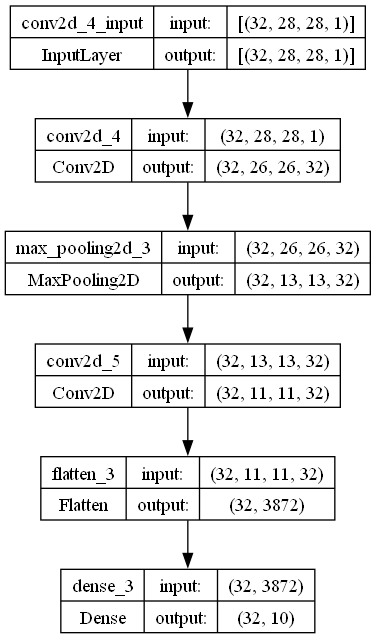

In [5]:
initializer_relu = initializers.random_normal
final_layer_activation = 'softmax'
training_loss = 'categorical_crossentropy'
input_shape = (28, 28, 1)
model = Sequential([Conv2D(32, (3, 3), activation='relu'),
                    MaxPooling2D((2, 2)),                            
                    Conv2D(32, (3, 3), activation='relu'),
                    Flatten(),
                    Dense(10, activation=final_layer_activation, kernel_initializer = initializer_relu)])
model.build(input_shape=(32, 28, 28, 1))
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 trop_conv2d (TropConv2D)    (32, 26, 26, 32)          320       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 13, 13, 32)         0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (32, 11, 11, 32)          9248      
                                                                 
 flatten (Flatten)           (32, 3872)                0         
                                                                 
 dense (Dense)               (32, 10)                  38730     
                                                                 
Total params: 48,298
Trainable params: 48,298
Non-trainable params: 0
____________________________________________________

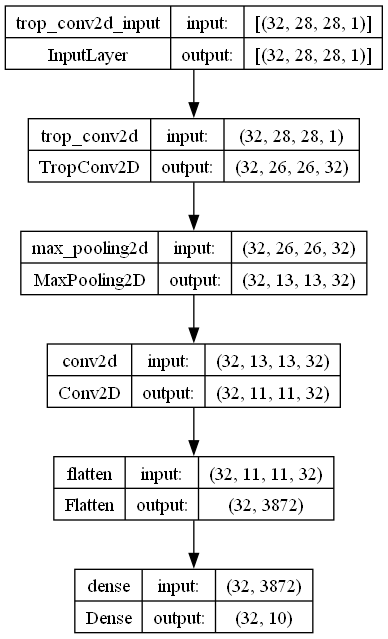

In [2]:
initializer_trop = initializers.random_normal
initializer_relu = initializers.random_normal

model = Sequential([TropConv2D(filters=32),
                    MaxPooling2D((2, 2)),                            
                    Conv2D(32, (3, 3), activation='relu'),
                    Flatten(),
                    Dense(10, activation='softmax', kernel_initializer = initializer_relu)])
model.build(input_shape=(32, 28, 28, 1))
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

### RESULTS: Degradation of prediction power from PGD attack

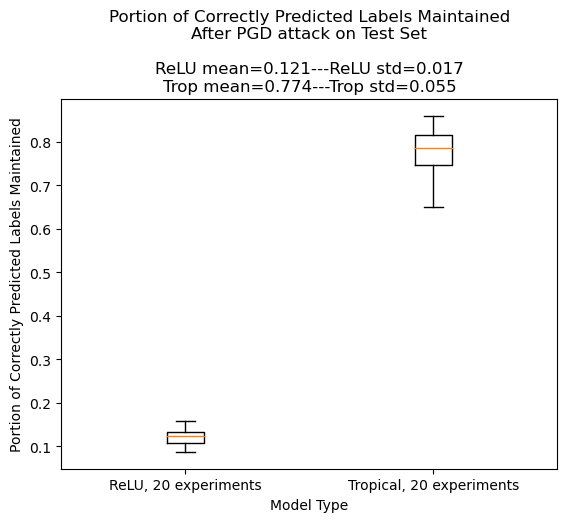

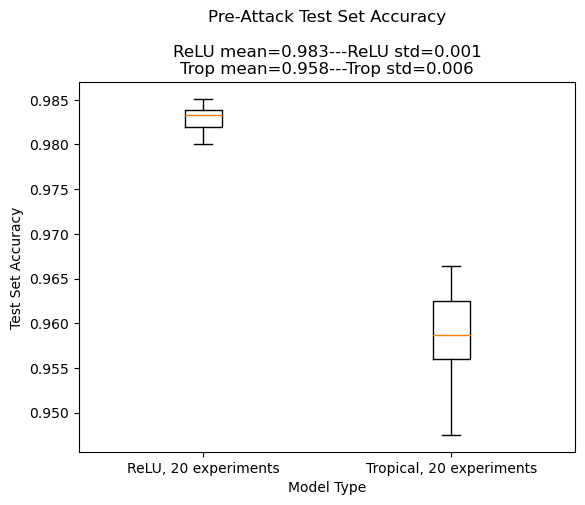

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

full_data = pd.read_csv('output_data/MNIST_relu_conv_results_30step.csv')
relu_data = full_data[full_data['model_type'] == 'relu']
trop_data = full_data[full_data['model_type'] == 'trop']

col1 = relu_data['maintained_correct_pred']
col2 = trop_data['maintained_correct_pred']
plt.boxplot([col1, col2], labels=[col1.mean(), col2.mean()])
plt.xticks([1, 2], [f'ReLU, {len(relu_data)} experiments', f'Tropical, {len(trop_data)} experiments'])  # Set x-axis labels
plt.xlabel('Model Type')  # Set the x-axis label
plt.ylabel('Portion of Correctly Predicted Labels Maintained')  # Set the y-axis label
plt.title(f'Portion of Correctly Predicted Labels Maintained\nAfter PGD attack on Test Set\n\nReLU mean={round(col1.mean(),3)}---ReLU std={round(col1.std(),3)}\nTrop mean={round(col2.mean(),3)}---Trop std={round(col2.std(),3)}')  # Set the title
plt.show()

col1 = relu_data['pre_acc']
col2 = trop_data['pre_acc']
plt.boxplot([col1, col2], labels=[col1.mean(), col2.mean()])
plt.xticks([1, 2], [f'ReLU, {len(relu_data)} experiments', f'Tropical, {len(trop_data)} experiments'])  # Set x-axis labels
plt.xlabel('Model Type')  # Set the x-axis label
plt.ylabel('Test Set Accuracy')  # Set the y-axis label
plt.title(f'Pre-Attack Test Set Accuracy\n\nReLU mean={round(col1.mean(),3)}---ReLU std={round(col1.std(),3)}\nTrop mean={round(col2.mean(),3)}---Trop std={round(col2.std(),3)}')  # Set the title
plt.show()

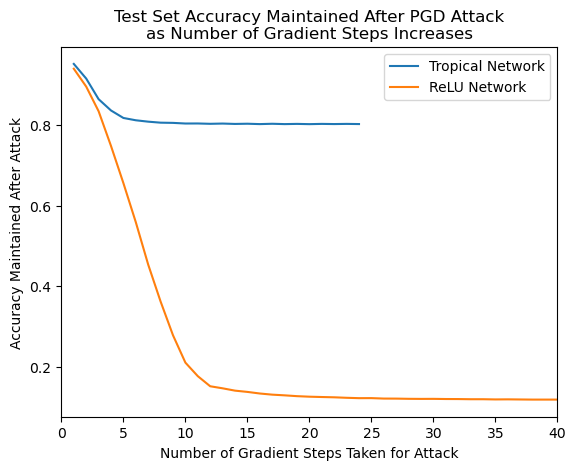

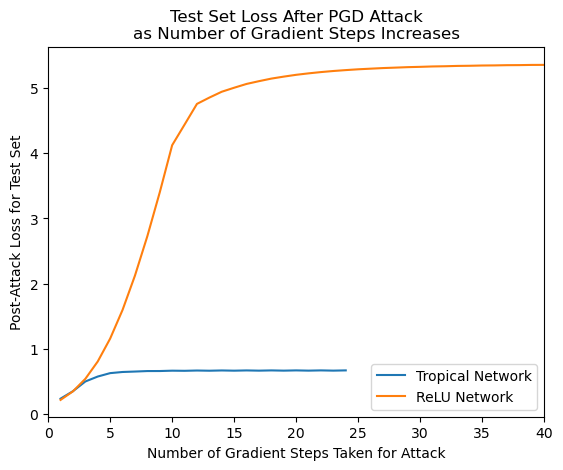

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

trop_res = pd.read_csv('output_data/MNIST_trop_conv_pgd_step_test.csv')
relu_res = pd.read_csv('output_data/MNIST_relu_conv_pgd_step_test.csv')

plt.plot(trop_res['num_steps'], trop_res['maintained_correct_pred'], label='Tropical Network')
plt.plot(relu_res['num_steps'], relu_res['maintained_correct_pred'], label='ReLU Network')
plt.title('Test Set Accuracy Maintained After PGD Attack\nas Number of Gradient Steps Increases')
plt.xlabel('Number of Gradient Steps Taken for Attack')
plt.ylabel('Accuracy Maintained After Attack')
plt.xlim((0,40))
plt.legend()
plt.show()

plt.plot(trop_res['num_steps'], trop_res['post_loss'], label='Tropical Network')
plt.plot(relu_res['num_steps'], relu_res['post_loss'], label='ReLU Network')
plt.title('Test Set Loss After PGD Attack\nas Number of Gradient Steps Increases')
plt.xlabel('Number of Gradient Steps Taken for Attack')
plt.ylabel('Post-Attack Loss for Test Set')
plt.xlim((0,40))
plt.legend()
plt.show()

